In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import pysam
import scipy.io as sio
import dnatools
from plot_tools import simpleaxis, plot_splicing_histogram
fsize=14
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14


/net/gs/vol3/software/modules-sw-python/2.7.3/pandas/0.14.0/Linux/RHEL6/x86_64/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


In this python notebook we will calculate basic statistics associated with the two splicing libraries. We will also make some of the plots from Figure 2.

### Make directory to save results:

In [2]:
resultsdir = '../results/N1_Library_Statistics/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
figdir = '../figures/N1_Library_Statistics/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
#Choose if you want to actually save the plots:
SAVEFIGS = True

### Load Library Data:

In [3]:
data = sio.loadmat('../data/Reads.mat')
A5SS_data = data['A5SS']
A3SS_data = data['A3SS']
A5SS_seqs = pd.read_csv('../data/A5SS_Seqs.csv',index_col=0)
A3SS_seqs = pd.read_csv('../data/A3SS_Seqs.csv',index_col=0)

### Size of Libraries:

Lets calculate the size of the library and the percent of the library for which we have RNA reads.

In [4]:
A5SS_reads_per_plasmid = np.array(A5SS_data.sum(1)).flatten()
A3SS_reads_per_plasmid = np.array(A3SS_data.sum(1)).flatten()

A5SS_nonzero_reads = A5SS_reads_per_plasmid>0
A3SS_nonzero_reads = A3SS_reads_per_plasmid>0

A5SS_num_plasmids = shape(A5SS_data)[0]
A3SS_num_plasmids = shape(A3SS_data)[0]

In [5]:
print 'A5SS:', sum(A5SS_nonzero_reads),'/',A5SS_num_plasmids,sum(A5SS_nonzero_reads)/float(A5SS_num_plasmids)
print 'A3SS:', sum(A3SS_nonzero_reads),'/',A3SS_num_plasmids,sum(A5SS_nonzero_reads)/float(A3SS_num_plasmids)

A5SS: 265044 / 265137 0.999649237941
A3SS: 1686096 / 2211739 0.119835116169


Let's calculate how many total reads we have for each library:

In [6]:
print 'Total Reads - A5SS: %i' %A5SS_data.sum()
print 'Total Reads - A5SS: %i' %A3SS_data.sum()

Total Reads - A5SS: 13257492
Total Reads - A5SS: 5472487


While we have RNA reads for almost all 5' library members, there are many 3' library members for which we have no RNA reads. So let's check the reads/plasmid for each library:

In [7]:
# Average reads per plasmid
A3SS_total_reads = float(A3SS_data.sum())
A5SS_total_reads = float(A5SS_data.sum())
print A5SS_total_reads/A5SS_num_plasmids
print A3SS_total_reads/A3SS_num_plasmids

50.0024213897
2.47429149642


### Plotting Histograms of Splice Site Usage in Each Library

We will now get the splicing data for each isoform in the 5' library. We have defined new splice sites as those occuring 7-35nt downstream as well as 50-75nt downstream of SD1.

In [8]:
# Convert Reads counts to fraction of ss usage:
A5SS_fraction = np.array(A5SS_data.todense())
A5SS_fraction = (A5SS_fraction.T/A5SS_fraction.sum(1)).T
# Remove plasmids with no reads
A5SS_fraction = A5SS_fraction[A5SS_reads_per_plasmid>0]

A5_isoforms = {}
A5_isoforms['SD_1']=A5SS_fraction[:,0]
A5_isoforms['SD_2']=A5SS_fraction[:,44]
A5_isoforms['SD_CRYPT']=A5SS_fraction[:,79]
A5_isoforms['SD_NEW']=A5SS_fraction[:,7:35].sum(axis=1)+A5SS_fraction[:,50:75].sum(axis=1)
A5_isoforms['No_SD'] = A5SS_fraction[:,303]
#A5_isoforms = pd.DataFrame(A5_isoforms)

Get the splicing data for each isoform in the 3' library:

In [9]:
# Get minigenes with reads
nn = A3SS_reads_per_plasmid>0

A3_isoforms = {}
A3_isoforms['SA_1']=np.array(A3SS_data[:,235].todense()).reshape(-1).astype(np.float64)[nn]/A3SS_reads_per_plasmid[nn]
A3_isoforms['SA_2']=np.array(A3SS_data[:,388].todense()).reshape(-1).astype(np.float64)[nn]/A3SS_reads_per_plasmid[nn]
A3_isoforms['SA_CRYPT']=np.array(A3SS_data[:,388-16].todense()).reshape(-1).astype(np.float64)[nn]/A3SS_reads_per_plasmid[nn]
A3_isoforms['SA_NEW']=np.array(A3SS_data[:,388-19-25:388-19].sum(axis=1)+A3SS_data[:,388+3:388+28].sum(axis=1)).reshape(-1).astype(np.float64)[nn]/A3SS_reads_per_plasmid[nn]
A3_isoforms['No_SA']=np.array(A3SS_data[:,0].todense()).reshape(-1).astype(np.float64)[nn]/A3SS_reads_per_plasmid[nn]


I've written a plotting function to make histograms of each splice site usage. It's a bit complex, but if you want to check it out its in PlotTools.plot_splicing_histogram. Lets use this to plot histograms for each splice sites. It will plot the mean usage for each site with a blue line an an indicated value:

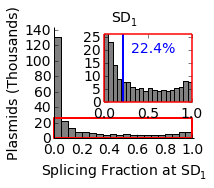

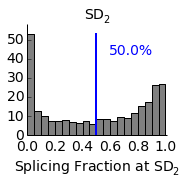

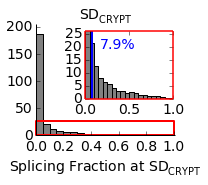

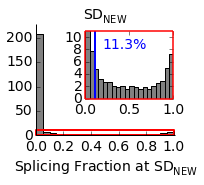

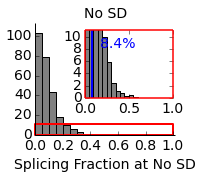

In [10]:
plot_splicing_histogram('SD_1','$SD_1$',A5_isoforms['SD_1'],
                        smallplot=True,
                        ylabel=True,
                        figdir=figdir,
                        save_plot=SAVEFIGS)
plot_splicing_histogram('SD_2','$SD_2$',A5_isoforms['SD_2'],
                        smallplot=False,
                        figdir=figdir,
                        save_plot=SAVEFIGS)
plot_splicing_histogram('SD_CRYPT','$SD_{CRYPT}$',A5_isoforms['SD_CRYPT'],
                        smallplot=True,
                        figdir=figdir,
                        save_plot=SAVEFIGS)
plot_splicing_histogram('SD_NEW','$SD_{NEW}$',A5_isoforms['SD_NEW'],
                        y_max=11,
                        y_step=2,
                        smallplot=True,
                        figdir=figdir,
                        save_plot=SAVEFIGS)
plot_splicing_histogram('No_SD','No SD',
                        A5_isoforms['No_SD'],
                        y_max=11,
                        y_step=2,
                        smallplot=True,
                        figdir=figdir,
                        save_plot=SAVEFIGS)


We can also use it to plot histograms for the isoforms in the 3' library:

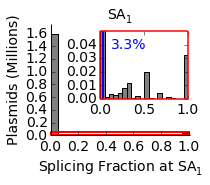

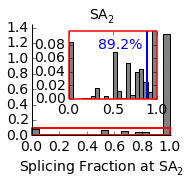

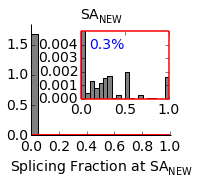

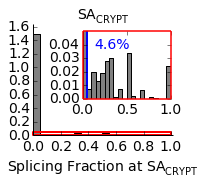

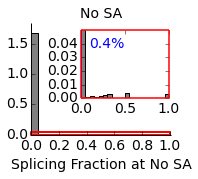

In [11]:
nn = A3SS_reads_per_plasmid>0
plot_splicing_histogram('SA_1','$SA_1$',A3_isoforms['SA_1'],
                        y_max=.050,
                        y_step=.010,
                        smallplot=True,
                        ylabel=True,
                        scale='M',
                        figdir=figdir,
                        save_plot=SAVEFIGS)
plot_splicing_histogram('SA_2','$SA_2$',A3_isoforms['SA_2'],
                        y_max=.100,
                        y_step=.02,
                        smallplot=True,
                        ylabel=False,
                        mean_pos=0.35,
                        smallplotpos=0.33,
                        scale='M',
                        figdir=figdir,
                        save_plot=SAVEFIGS)
plot_splicing_histogram('SA_NEW','$SA_{NEW}$',A3_isoforms['SA_NEW'],
                        y_max=.005,
                        y_step=.001,
                        smallplot=True,
                        ylabel=False,
                        scale='M',
                        figdir=figdir,
                        save_plot=SAVEFIGS)
plot_splicing_histogram('SA_CRYPT','$SA_{CRYPT}$',A3_isoforms['SA_CRYPT'],
                        y_max=.050,
                        y_step=.010,
                        smallplot=True,
                        ylabel=False,
                        scale='M',
                        figdir=figdir,
                        save_plot=SAVEFIGS)
plot_splicing_histogram('No_SA','No SA',A3_isoforms['No_SA'],
                        y_max=.050,
                        y_step=.010,
                        smallplot=True,
                        ylabel=False,
                        scale='M',
                        figdir=figdir,
                        save_plot=SAVEFIGS)

### Statistics for each library in paper text

#### A5SS:

In [12]:
print 'Percent of minigenes spliced at SD1 less than 5%:', mean(A5_isoforms['SD_1']<0.05),\
                                                           sum(A5_isoforms['SD_1']<0.05)
print 'Percent of minigenes spliced at SD1 more than 95%:', mean(A5_isoforms['SD_1']>0.95),\
                                                           sum(A5_isoforms['SD_1']>0.95)

Percent of minigenes spliced at SD1 less than 5%: 0.493536922171 130809
Percent of minigenes spliced at SD1 more than 95%: 0.0290706448741 7705


#### A3SS:

Find how many cryptic splice sites were used between 0.00001% and 0.5% of the time:

In [13]:
A3_fraction_by_SA = np.array(A3SS_data.sum(axis=0),dtype=np.float).flatten()/A3SS_data.sum()
cryptic_SAs = (A3_fraction_by_SA>=1e-7) & (A3_fraction_by_SA<=5e-3)
print 'Number of different unique cryptic SA positions:',sum(cryptic_SAs)
print 'Percentage of reads mapping to these cryptic SAs:',A3_fraction_by_SA[cryptic_SAs].sum()

Number of different unique cryptic SA positions: 392
Percentage of reads mapping to these cryptic SAs: 0.0231284240602


In [14]:
multiple_read_minigenes = find(A3SS_reads_per_plasmid>1)
np.array(A3SS_data[multiple_read_minigenes,0].todense()).flatten()

array([0, 0, 0, ..., 0, 0, 0])

Find the percent of plamids with multiple reads that use SA1 100% of the time:

In [15]:
multiple_read_minigenes = find(A3SS_reads_per_plasmid>1)
SA1_multiple_reads = np.array(A3SS_data[multiple_read_minigenes,235].todense(),
                              dtype=np.float).flatten()/\
                     A3SS_reads_per_plasmid[multiple_read_minigenes]
    
print float(sum(SA1_multiple_reads==1))/len(SA1_multiple_reads),\
      sum(SA1_multiple_reads==1),'/',len(SA1_multiple_reads)

0.00735002805258 8738 / 1188839
